
##  평가 기준

###  KITTI 데이터셋에 대한 분석이 체계적으로 진행되었다.

KITTI 데이터셋 구조와 내용을 파악하고 이를 토대로 필요한 데이터셋 가공을 정상 진행하였다.


### RtinaNet 학습이 정상적으로 진행되어 object detection 결과의 시각화까지 진행되었다.


바운딩박스가 정확히 표시된 시각화된 이미지를 생성하였다.


### 자율주행 Object Detection 테스트시스템 적용결과 만족스러운 정확도 성능을 달성하였다.


테스트 수행결과 90% 이상의 정확도를 보였다.

## 1. KITTI 데이터셋 확인

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image, ImageDraw

In [2]:
import urllib3
urllib3.disable_warnings()

data_dir = os.path.join(os.getenv("HOME"), "aiffel/object_detection/data")

(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    data_dir=data_dir,
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,)

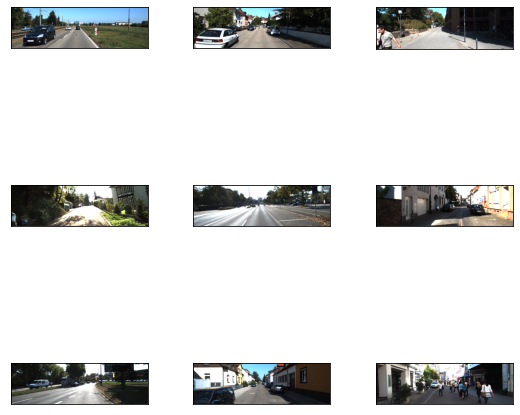

In [3]:
_ = tfds.show_examples(ds_train, ds_info)

In [4]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.2.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='/aiffel/aiffel/object_detection/data/kitti/3.2.0',
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
     

-----Example-----
['image', 'image/file_name', 'objects']
-----objects-----
{'alpha': <tf.Tensor: shape=(5,), dtype=float32, numpy=array([ 1.85, -1.95, -1.77, -1.75,  1.42], dtype=float32)>, 'bbox': <tf.Tensor: shape=(5, 4), dtype=float32, numpy=
array([[0.02714667, 0.17914654, 0.5016533 , 0.3913446 ],
       [0.01125333, 0.60625607, 0.62869334, 0.87033814],
       [0.2984    , 0.55256844, 0.5174933 , 0.6397504 ],
       [0.36826667, 0.53321254, 0.52058667, 0.5942834 ],
       [0.4824    , 0.534066  , 0.54488   , 0.55818033]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[1.55, 1.68, 4.42],
       [2.  , 1.76, 4.61],
       [1.6 , 1.53, 4.18],
       [1.56, 1.57, 3.98],
       [1.79, 1.72, 4.35]], dtype=float32)>, 'location': <tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[-2.74,  1.75,  8.73],
       [ 3.11,  1.74,  8.63],
       [ 2.75,  1.79, 16.29],
       [ 2.61,  1.79, 22.  ],
       [ 5.41,  1.65, 57.78]], dtype=float32)>, 'occlud

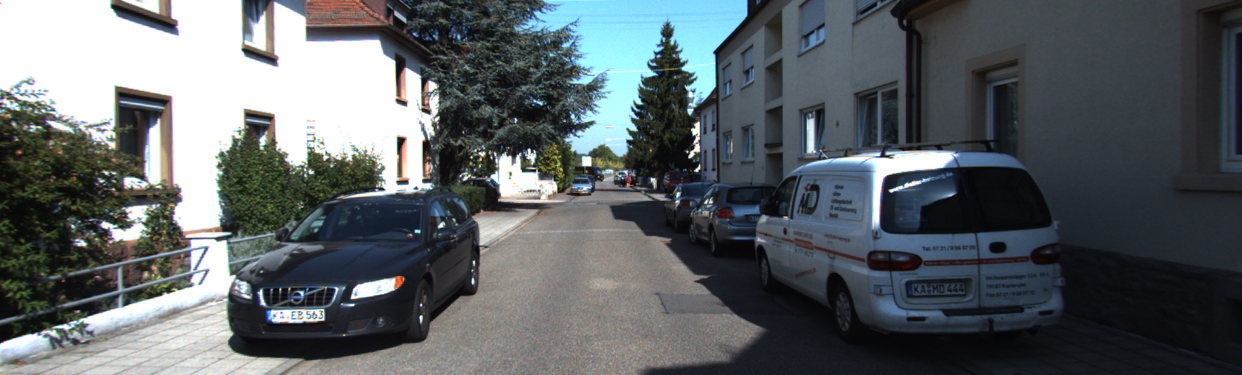

In [5]:
sample = ds_train.take(1)

for example in sample:
    print('-----Example-----')
    print(list(example.keys()))
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('-----objects-----')
print(objects)

img = Image.fromarray(image.numpy())
img

width: 1242  height: 375
(5, 4)
[222.5  364.82 486.05 186.88]
[ 752.97003  370.78    1080.96     139.23999]
[686.29    263.09998 794.57    180.94   ]
[662.25 236.9  738.1  179.78]
[663.31    194.1     693.25995 170.67001]
<PIL.Image.Image image mode=RGB size=1242x375 at 0x7FDFE0474290>


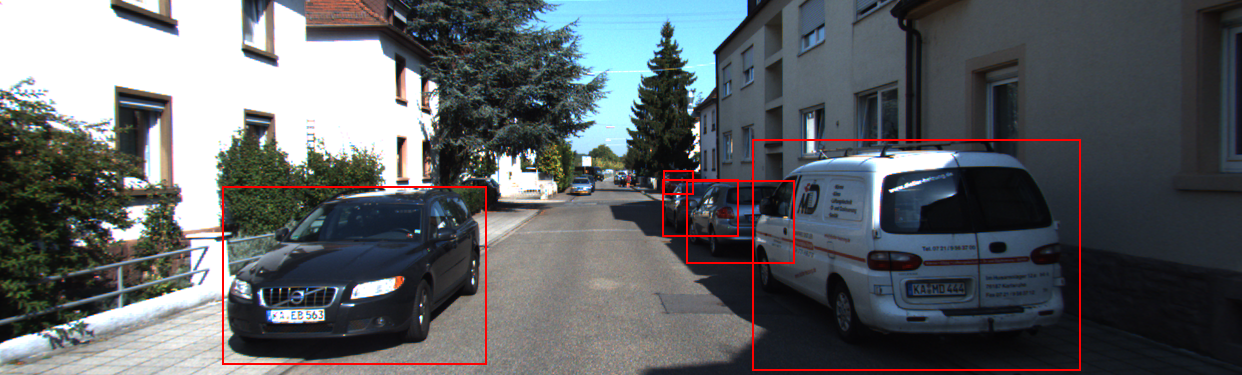

In [6]:
# 이미지 위에 바운딩 박스를 그려 화면에 표시해 주세요.
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)
    
    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    print('width:', width, ' height:', height)
    print(object_bbox.shape)
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height
    
    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        print(_rect)
        draw.rectangle(_rect, outline=(255,0,0), width=2)
    print(input_image)
    return input_image

visualize_bbox(img, objects['bbox'].numpy())

## 2. keras-retinanet 학습

### 2.1 데이터 포맷 변경

In [7]:
import os
data_dir = os.getenv('HOME') + '/aiffel/object_detection/data'
img_dir = data_dir + '/kitti_images'
train_csv_path = data_dir + 'kitti_train.csv'

# KITTI 데이터셋 ds_train을 파싱해서 dataframe으로 변환하는
# parse_dataset 힘수를 구현해 주세요.
def parse_dataset(dataset, img_dir, total=0):
    if not os.path.exists(img_dir):
        os.mkdir(img_dir)
        
    # Dataset의 class를 확인하여 class에 따른 index를 확인해둡니다.
    # 기존의 class를 차와 사람으로 나누었습니다.
    type_class_map = {
        0: 'car',
        1: 'car',
        2: 'car',
        3: 'person',
        4: 'person',
        5: 'person',
    }
    # Keras retinanet을 학습하기 위한 dataset을 csv로 parsing하기 위해서
    # 필요한 column을 가진 pandas.DataFrame을 생성합니다.
    df = pd.DataFrame(columns=['img_path', 'x1', 'y1', 'x2', 'y2', 'class_name'])
    for item in tqdm(dataset, total=total):
        filename = item['image/file_name'].numpy().decode('utf-8')
        img_path = os.path.join(img_dir, filename)
        
        img = Image.fromarray(item['image'].numpy())
        img.save(img_path)
        object_bbox = item['objects']['bbox']
        object_type = item['objects']['type'].numpy()
        width, height = img.size
        
        # tf.dataset의 bbox좌표가 0과 1사이로 normalize된 좌표이므로 이를 pixel좌표로 변환합니다.
        x_min = object_bbox[:,1] * width
        x_max = object_bbox[:,3] * width
        y_min = height - object_bbox[:,2] * height
        y_max = height - object_bbox[:,0] * height
        
        # 한 이미지에 있는 여러 Object들을 한 줄씩 pandas.DataFrame에 append합니다.
        rects = np.stack([x_min, y_min, x_max, y_max], axis=1).astype(np.int)
        for i, _rect in enumerate(rects):
            _type = object_type[i]
            if _type not in type_class_map.keys():
                continue
            df = df.append({
                "img_path": img_path,
                "x1": _rect[0],
                "y1": _rect[1],
                "x2": _rect[2],
                "y2": _rect[3],
                "class_name": type_class_map[_type]
            }, ignore_index=True)
            
    return df

df_train = parse_dataset(ds_train, img_dir, total=ds_info.splits['train'].num_examples)
df_train.to_csv(train_csv_path, sep=',', index=False, header=False)

100%|██████████| 6347/6347 [22:26<00:00,  4.71it/s]


In [8]:
test_csv_path = data_dir + 'kitti_test.csv'

df_test = parse_dataset(ds_test, img_dir, total=ds_info.splits['test'].num_examples)
df_test.to_csv(test_csv_path, sep=',', index=False, header=False)

100%|██████████| 711/711 [02:36<00:00,  4.54it/s]


In [9]:
class_txt_path = data_dir + '/classes.txt'

def save_class_format(path):
    class_type_map = {
        "car": 0,
        "person" : 1
    }
    with open(path, mode='w', encoding='utf-8') as f:
        for k, v in class_type_map.items():
            f.write(f"{k},{v}\n")
    print('Done')
    
save_class_format(class_txt_path)

Done


### 2.2 모델 학습

In [10]:
# RetinaNet 훈련이 시작됩니다!! 10epoch 훈련에 1시간 이상 소요될 수 있습니다. 
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/train.py --gpu 0 --multiprocessing --workers 4 --batch-size 2 --epochs 10 --steps 195 csv data/kitti_train.csv data/classes.txt
print("Done")

2021-10-19 06:47:44.187330: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-19 06:47:45.913424: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-19 06:47:45.914442: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-19 06:47:45.922360: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0001:00:00.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2021-10-19 06:47:45.922399: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-19 06:47:45.925373: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-10-19

In [11]:
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/convert_model.py snapshots/resnet50_csv_10.h5 snapshots/resnet50_csv_10_infer.h5
print("Done")

2021-10-19 07:27:45.891272: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-19 07:27:47.533220: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-19 07:27:47.534239: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-19 07:27:47.541621: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0001:00:00.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2021-10-19 07:27:47.541665: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-19 07:27:47.545526: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-10-19

### 2.3 시각화

In [12]:
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.models import load_model
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

gpu = '0'
setup_gpu(gpu)

dir_path = os.getenv('HOME') + '/aiffel/object_detection/'
model_path = os.path.join(dir_path, 'snapshots', 'resnet50_csv_10_infer.h5')
model = load_model(model_path, backbone_name='resnet50')

Physical devices cannot be modified after being initialized
1 Physical GPUs, 1 Logical GPUs


[177.04854 124.1808  341.17722 222.80441]
[550.22394 160.4385  586.06866 192.90686]
[342.5373  169.81668 395.4823  197.50851]
[617.7075  151.77281 674.14795 179.40683]
[405.91855 159.54333 446.93652 186.74886]
[493.0653  154.82043 529.89044 180.46724]
[481.1806  156.77257 518.50964 179.15833]


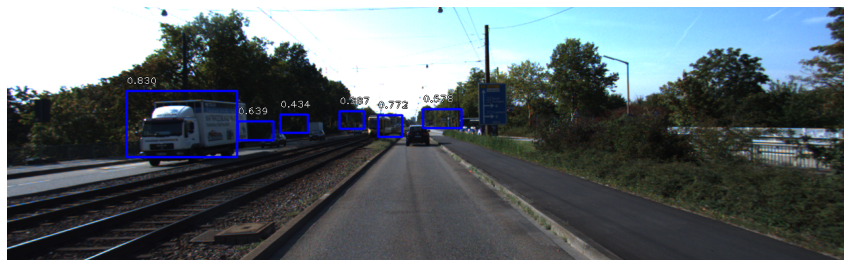

([array([177.04854, 124.1808 , 341.17722, 222.80441], dtype=float32),
  array([550.22394, 160.4385 , 586.06866, 192.90686], dtype=float32),
  array([342.5373 , 169.81668, 395.4823 , 197.50851], dtype=float32),
  array([617.7075 , 151.77281, 674.14795, 179.40683], dtype=float32),
  array([405.91855, 159.54333, 446.93652, 186.74886], dtype=float32),
  array([493.0653 , 154.82043, 529.89044, 180.46724], dtype=float32),
  array([481.1806 , 156.77257, 518.50964, 179.15833], dtype=float32)],
 [0, 0, 0, 0, 0, 0, 0])

In [13]:
import os
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/go_1.png'

# inference_on_image 함수를 구현해 주세요.
def inference_on_image(model, img_path, visualize=True):
    image = read_image_bgr(img_path)

    # TODO: copy image to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
    
    color_map = {
        0: (0, 0, 255),
        1: (255, 0, 0)
    }

    # TODO: preprocess image for network
    image = preprocess_image(image)
    imgae, scale = resize_image(image)

    # TODO: process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    
    # TODO: correct for image scale
    boxes /= scale
    
    box_arr = []
    label_arr = []
    
    # TODO: display images
    if visualize:
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            
            box_arr.append(box)
            label_arr.append(label)
            print(box)
            if score < 0.3:
                break
            b = box.astype(int)
            draw_box(draw, b, color=color_map[label])
            
            caption = "{:.3f}".format(score)
            draw_caption(draw, b, caption)
            
        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.imshow(draw)
        plt.show()
    
    return box_arr, label_arr
    
inference_on_image(model, img_path)

[707.7171  139.09665 775.40247 285.30225]
[729.35046 143.37785 797.947   275.98178]


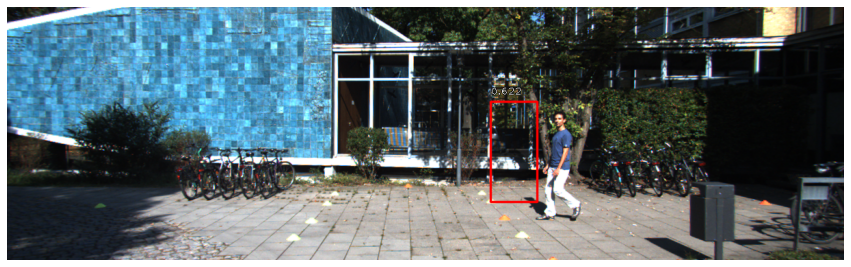

([array([707.7171 , 139.09665, 775.40247, 285.30225], dtype=float32),
  array([729.35046, 143.37785, 797.947  , 275.98178], dtype=float32)],
 [1, 1])

In [14]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_1.png'
inference_on_image(model, img_path)

## 3. 자율주행 보조 시스템 만들기
### 3.1 자율주행 시스템 만들기
* 입력으로 이미지 경로 받기
* 다음 정지조건에 맞는 경우 "Stop", 아닌 경우 "Go"를 반환
    * 사람이 한 명 이상 있는 경우
    * 차량의 크기(width or height)가 300px 이상인 경우

[385.1093  157.96497 458.94278 306.91046]
[397.48325 153.4713  441.2699  268.39722]


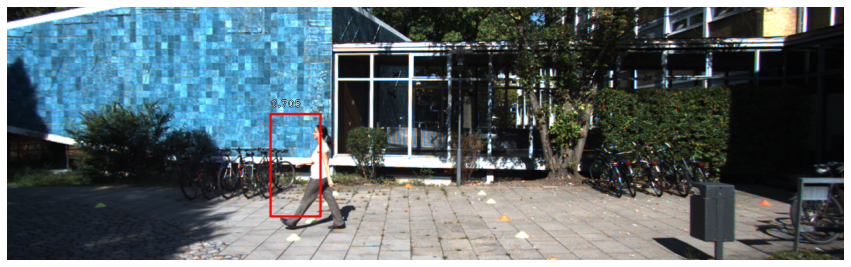

Stop


In [17]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_2.png'

def self_drive_assist(img_path, size_limit=300):
    box_arr, label_arr = inference_on_image(model, img_path)
    for box, label in zip(box_arr, label_arr):
        w = abs(box[0] - box[2])
        h = abs(box[1] - box[3])
        
        if label == 1 or w >= size_limit or h >= size_limit:
            return 'Stop'
        else:
            return 'Go'

print(self_drive_assist(img_path))

### 3.2 자율주행 시스템 평가하기

[707.7171  139.09665 775.40247 285.30225]
[729.35046 143.37785 797.947   275.98178]


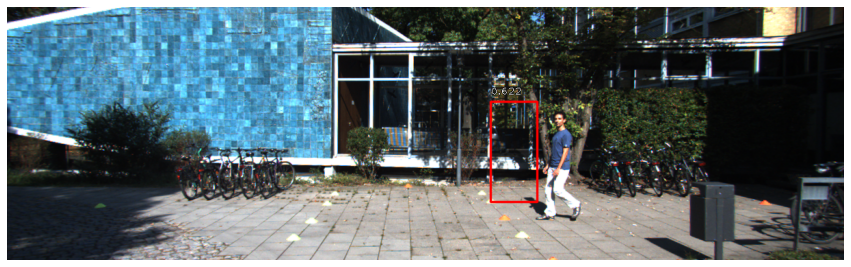

test_set/stop_1.png
prediction: Stop, answer: Stop

[385.1093  157.96497 458.94278 306.91046]
[397.48325 153.4713  441.2699  268.39722]


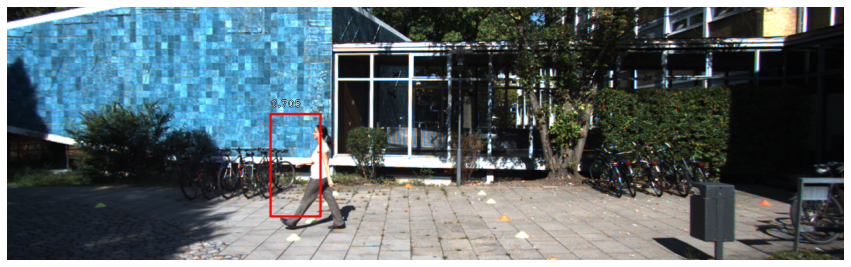

test_set/stop_2.png
prediction: Stop, answer: Stop

[  0.      180.37383 288.49173 338.8267 ]
[678.44824 145.49294 819.46326 199.32628]
[912.1266  128.56268 952.901   216.21767]
[900.4884  127.53104 935.1164  201.11482]


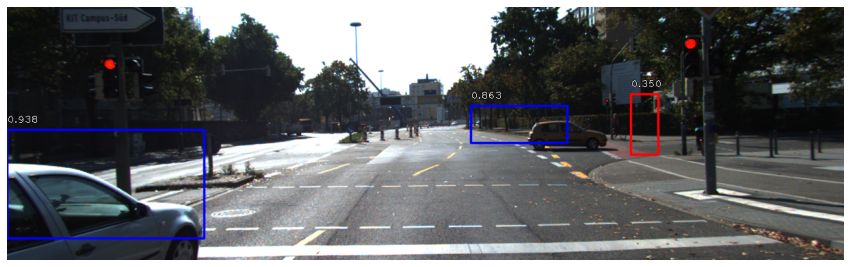

test_set/stop_3.png
prediction: Go, answer: Stop

[601.75854 129.28934 694.95447 211.92285]
[ 31.446623 148.82379  334.383    297.24625 ]
[ 700.3694     33.908752 1081.9645    305.0809  ]
[390.11862 152.65164 518.7553  195.69244]
[316.05524 159.6463  453.84888 208.81122]
[ 89.91365 107.08001 369.53812 270.1863 ]
[441.34354 155.41449 527.9581  190.1292 ]
[603.83417 145.01952 667.09564 200.78244]
[265.20135 156.38428 428.18753 218.2082 ]


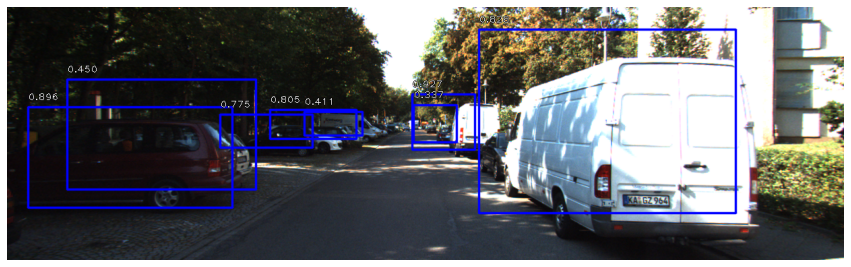

test_set/stop_4.png
prediction: Go, answer: Stop

[ 844.5254   128.73569 1156.2806   319.98276]
[675.81604 151.21436 804.89716 232.0764 ]
[650.21716 137.79602 738.3995  203.89827]
[527.1732  168.75194 572.433   202.81917]
[644.96075 140.8934  702.86584 194.35725]
[442.4169  160.9762  488.38382 207.60155]


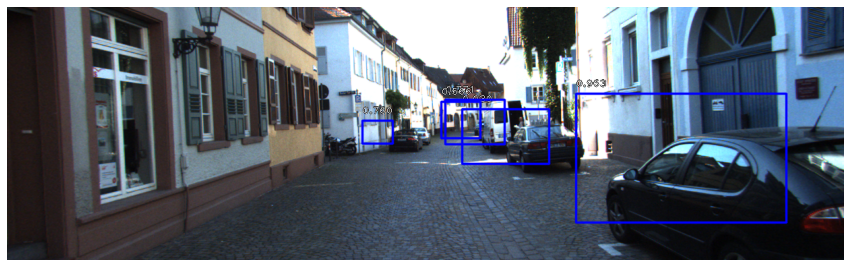

test_set/stop_5.png
prediction: Stop, answer: Stop

[177.04854 124.1808  341.17722 222.80441]
[550.22394 160.4385  586.06866 192.90686]
[342.5373  169.81668 395.4823  197.50851]
[617.7075  151.77281 674.14795 179.40683]
[405.91855 159.54333 446.93652 186.74886]
[493.0653  154.82043 529.89044 180.46724]
[481.1806  156.77257 518.50964 179.15833]


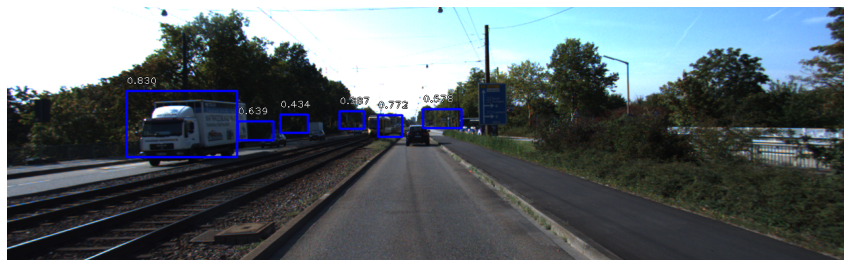

test_set/go_1.png
prediction: Go, answer: Go

[479.38474 163.4537  532.54346 199.74782]
[584.59717 163.16718 620.0669  198.82684]
[500.1328 159.9067 548.605  189.9892]


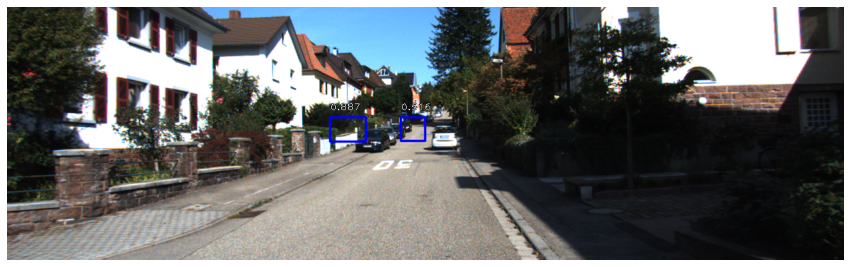

test_set/go_2.png
prediction: Go, answer: Go

[740.78815 134.47623 821.07056 167.43762]
[487.6338  151.37762 519.02954 176.00516]
[499.58817 150.363   528.7167  175.1313 ]


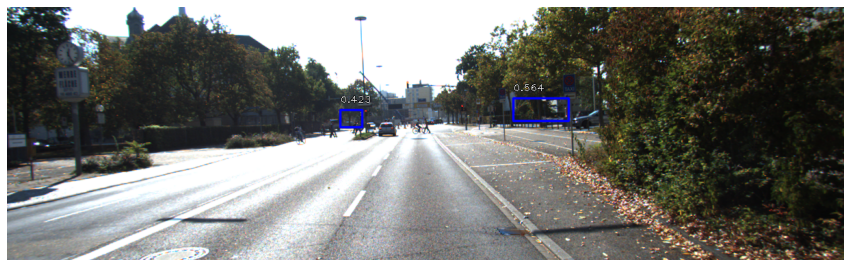

test_set/go_3.png
prediction: Go, answer: Go

[644.3231  152.74216 738.6829  239.28745]
[645.3195  152.58989 741.6592  243.18765]


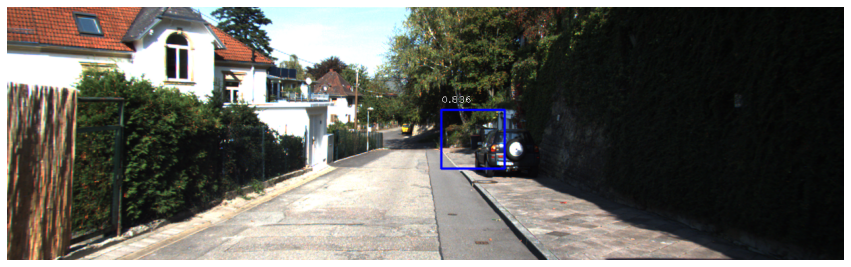

test_set/go_4.png
prediction: Go, answer: Go

[  0.      178.29279 226.58821 288.66354]
[144.98915 163.5307  335.37552 242.52214]
[290.73746 163.2991  409.2712  210.83826]
[405.3676  164.05156 461.98676 196.5511 ]
[ 66.1787  171.63075 308.84808 254.24512]
[234.27089 159.46243 394.55527 217.65012]
[ 996.4281   125.76566 1156.2806   194.8802 ]
[605.2364  156.39001 636.7194  178.10628]
[333.18283 164.40326 433.04266 206.9956 ]
[369.26447 164.47841 450.47595 199.5193 ]
[731.7225 143.4143 863.5011 189.8707]
[791.28467 126.76982 960.7363  182.48068]


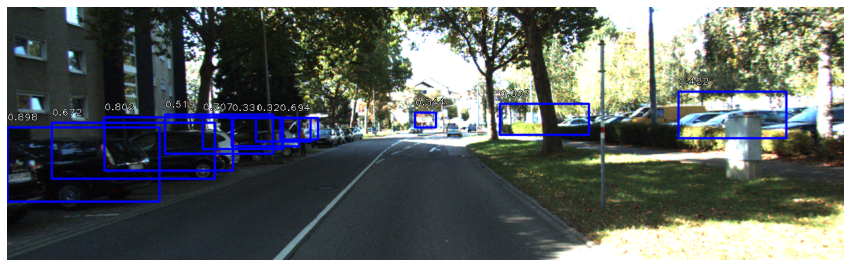

test_set/go_5.png
prediction: Go, answer: Go

80점입니다.


In [18]:
import os

def test_system(func):
    work_dir = os.getenv('HOME')+'/aiffel/object_detection'
    score = 0
    test_set=[
        ("test_set/stop_1.png", "Stop"),
        ("test_set/stop_2.png", "Stop"),
        ("test_set/stop_3.png", "Stop"),
        ("test_set/stop_4.png", "Stop"),
        ("test_set/stop_5.png", "Stop"),
        ("test_set/go_1.png", "Go"),
        ("test_set/go_2.png", "Go"),
        ("test_set/go_3.png", "Go"),
        ("test_set/go_4.png", "Go"),
        ("test_set/go_5.png", "Go"),
    ]
    
    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(img_path=image_path)
        print(image_file)
        print(f'prediction: {pred}, answer: {answer}\n')
        
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

test_system(self_drive_assist)


##  회고

저의 꿈인 자율주행 부분이라서 너무나 큰 설렘을 갖고 노드를 시작했습니다.

모델의 최종 스코어는 80점입니다. 스코어를 더 올리고 싶어서 시간이 오래 걸리는 것을 알지만 epoch를 10~40까지 변경하면서 모델학습을 시켰지만 80점을 넘지 못했습니다. 이해가 안되는 것은 각 사진에 대한 모델의 예측이 바뀐 것도 아닌데 왜 epoch변경으로 점수가 오르지 않았을까요?

저의 결론은 이번 노드에서는 불가능이라는 것이라고 생각이됩니다. 왜냐하면, 실제 테슬라에서 자율주행 자동차의 정지 조건을 만들었을 때 되게 복잡한데 이번 노드에서는 너무 단순하기 때문입니다. 단순히 이미지 내의 차량 크기가 300px이상인 경우와 사람이 존재하는 경우에는  모두 정지하게했기 때문입니다.


실제로 이런 단순한 조건은 차량의 조건에 만족하지 않은 경우에도, 먼 거리에 사람이 검출되었다는 적절하지 않은 이유만으로도 Stop라는 예측을 하게 만들것이기 때문입니다.

이렇게 되면, 실제 차랑의 움직임 여부 판단은 중요하지 않은 상태에서 단순한 이미지의 객체 하나만으로 출발과 정지가 결정이 되게 됩니다.

이게, 진정 자율주행을 위한 노드인가 싶습니다. 차라리 object detection 노드와 자율 주행 시스템에 대한 원리 노드를 따로 분리하여 했으면 어땠을까 하는 아쉬움이 있습니다.

만드신 분의 노고로를 뭐라고 하는 것이 아니라 그저 기대했고 고대했던 노드였는데 이런 아쉬움이 남습니다.

 
  
|epochs|socre|
|---|---|
|10|80|
|20|70|
|30|80|
|40|80|